# Training and Evaluation for All Features

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

cv_token_pattern = u'[^;]+'

In [42]:
def train_plot_roc(X, y, n_splits=10):
    # Trying ROC
    skf = StratifiedKFold(n_splits=n_splits)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 0.25])
    plt.ylim([0.50, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (mean_fpr, mean_tpr, classifier)

In [33]:
imports = pd.read_csv(build_path('learn_imports')).set_index('link')
categories = pd.read_csv(build_path('learn_behav_categories')).set_index('link')
apis = pd.read_csv(build_path('learn_behav_api_calls')).set_index('link')
signatures = pd.read_csv(build_path('learn_signatures')).set_index('link')

In [34]:
big_dataset = imports.drop('malware', axis=1).join(categories.drop('malware', axis=1), how='inner', lsuffix='cat_').join(
  apis.drop('malware', axis=1), how='inner', lsuffix='apis_').join(signatures.drop('malware', axis=1), how='inner')

In [35]:
malware = imports[imports.malware == True].index
malware = malware.join(categories[categories.malware == True].index)
malware = malware.join(apis[apis.malware == True].index)
malware = malware.join(signatures[signatures.malware == True].index)

In [36]:
goodware = imports[imports.malware == False].index
goodware = goodware.join(categories[categories.malware == False].index)
goodware = goodware.join(apis[apis.malware == False].index)
goodware = goodware.join(signatures[signatures.malware == False].index)

In [37]:
malware_labeled = pd.read_csv(build_path('malware_labeled')).set_index('link')
malware_labeled = malware_labeled.astype(float)

In [38]:
big_dataset.loc[big_dataset.index.isin(malware), 'malware'] = True
big_dataset.loc[big_dataset.index.isin(goodware), 'malware'] = False

In [39]:
malware = big_dataset[(big_dataset.malware == 1) & (big_dataset.index.isin(malware_labeled.index))].index
goodware = big_dataset[(big_dataset.malware == 0) & ~(big_dataset.index.isin(malware_labeled.index))].index
big_dataset = big_dataset[(big_dataset.index.isin(malware)) | (big_dataset.index.isin(goodware))]

In [46]:
# Create csv of indexes so that every classifier uses the same samples, enables comparison
big_dataset.index.to_frame().to_csv(build_path('all_samples'), compression='gzip')

## Baseline Classifier
Single LR for malware vs goodware using static imports

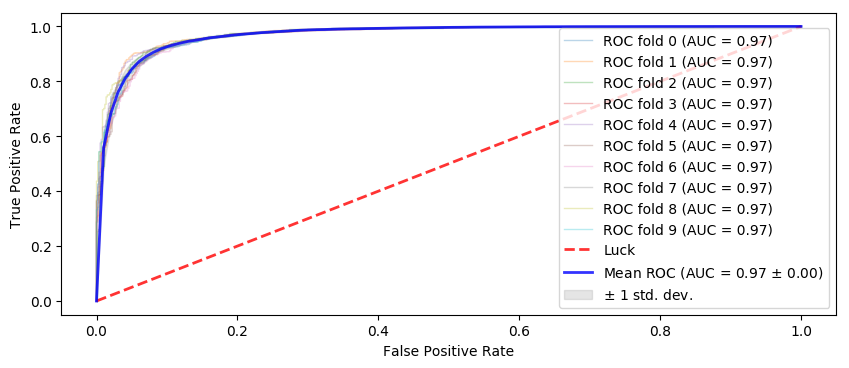

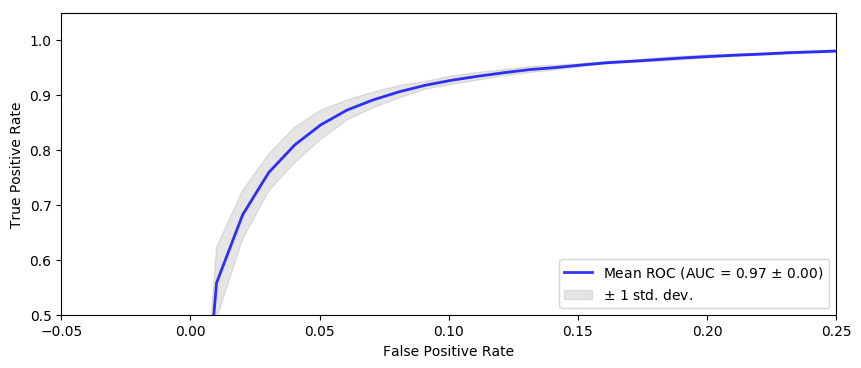

CPU times: user 4min 22s, sys: 6.18 s, total: 4min 28s
Wall time: 4min 21s


In [43]:
%%time
data = shuffle(big_dataset)
train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

## Class classifier

LR for each malware class, one-vs-all scenarios

In [20]:
mal_classes = list(malware_labeled.columns)

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[mclass].dropna()
    #mal = malware_labeled[~malware_labeled[mclass].isna()].index
    #mal = malwr_pe32[malwr_pe32.md5.isin(mal)]
    #mal = mal[~mal.index.isin(goodware.index)]
    datasets[mclass] = mal.index

'Testing other...'

'other: 52504'

'other: 91548'

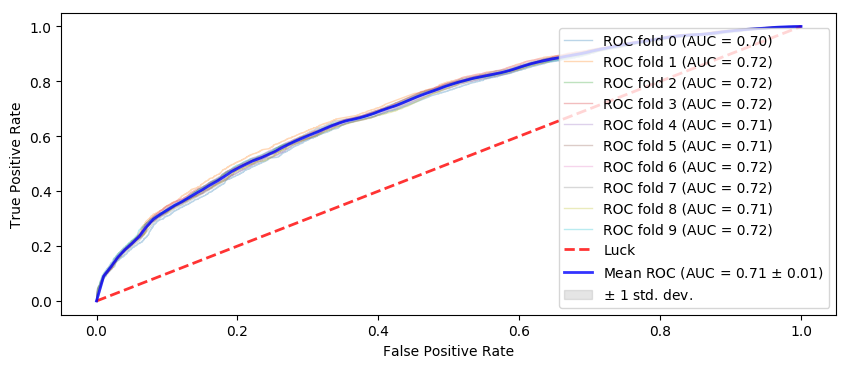

'Testing ransom...'

'ransom: 8525'

'other: 135527'

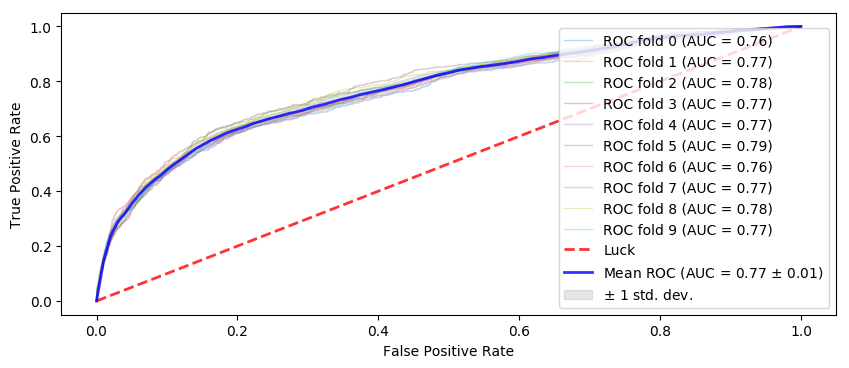

'Testing spyware...'

'spyware: 22043'

'other: 122009'

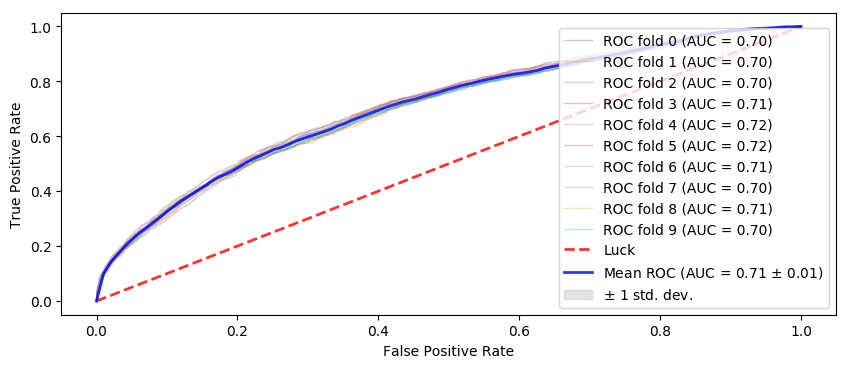

'Testing trojan...'

'trojan: 113002'

'other: 31050'

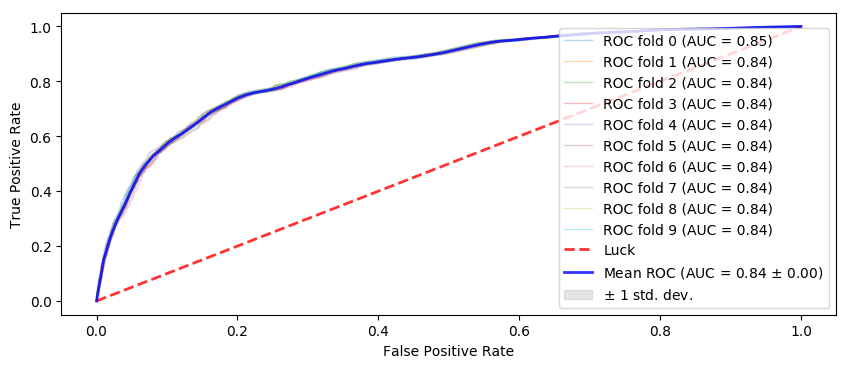

'Testing virus...'

'virus: 21906'

'other: 122146'

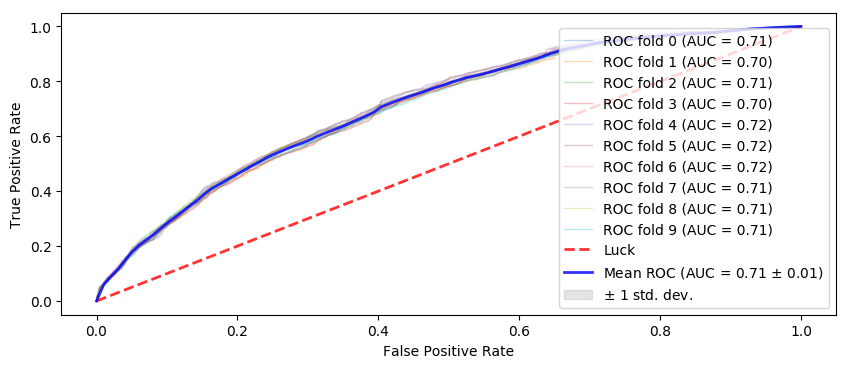

'Testing worm...'

'worm: 24943'

'other: 119109'

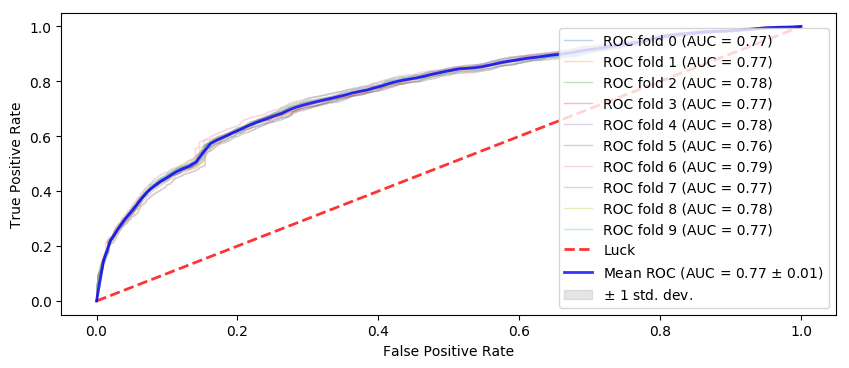

CPU times: user 3min 39s, sys: 31.8 s, total: 4min 11s
Wall time: 3min 29s


In [23]:
%%time
classifiers = dict()
final_rocs = dict()
for mclass in mal_classes:
    display('Testing {}...'.format(mclass))

    mal = big_dataset3[(big_dataset3.malware == True) & (big_dataset3.index.isin(datasets[mclass]))]
    mal.is_copy = False
    mal.loc[:, 'malware'] = True
    not_mal = big_dataset3[~(big_dataset3.index.isin(datasets[mclass]))]
    not_mal.is_copy = False
    not_mal.loc[:, 'malware'] = False
    
    data = shuffle(pd.concat([mal, not_mal]))
    display('{}: {}'.format(mclass, len(mal)))
    display('other: {}'.format(len(not_mal)))
    assert len(big_dataset3) == len(data)
    
    X = np.array(data.drop('malware', axis=1))
    y = data.malware
    mean_fpr, mean_tpr, classifier = train_plot_roc(X, y)
    final_rocs[mclass] = (mean_fpr, mean_tpr)
    classifiers[mclass] = classifier.fit(X, y)

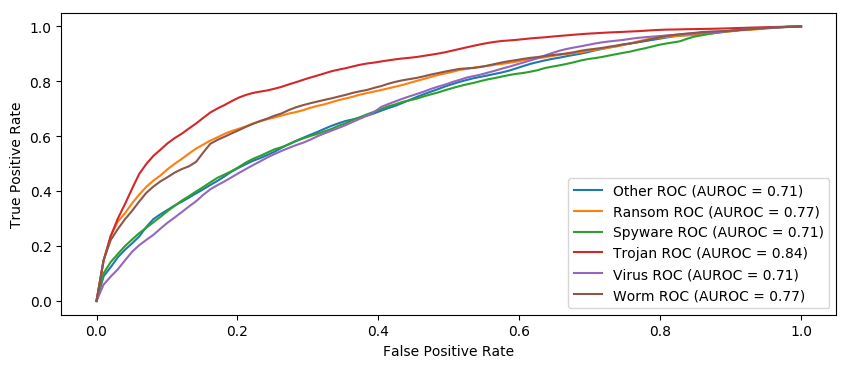

In [24]:
plt.figure(figsize=(10, 4), dpi=100)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
for mclass in mal_classes:
    plt.plot(final_rocs[mclass][0],
             final_rocs[mclass][1],
             label='{} ROC (AUROC = {:.2f})'.format(mclass.capitalize(), auc(final_rocs[mclass][0], final_rocs[mclass][1])))
plt.legend(loc="lower right")
plt.show()

## Ensemble Classifier
Joins previous classifiers into ensemble

In [31]:
# Join to big_dataset classification from smaller classifiers
X = big_dataset3.drop('malware', axis=1)
big_dataset4 = pd.DataFrame(columns=mal_classes, index=big_dataset3.index)
for mclass in mal_classes:
    probs = classifiers[mclass].predict_proba(X)[:,1]
    results = pd.DataFrame(index=big_dataset3.index, data=classifiers[mclass].predict_proba(X)[:,1], columns=[mclass])
    big_dataset4.loc[:, mclass] = results
big_dataset4.loc[:, 'malware'] = big_dataset3.malware

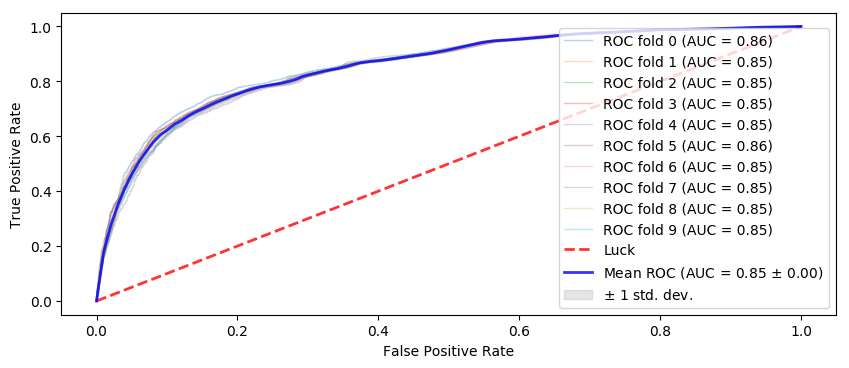

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

In [33]:
data = shuffle(big_dataset4)
train_plot_roc(np.array(data.drop('malware', axis=1)), data.malware)

## Dataset creation

In [5]:
big_dataset = pd.DataFrame(columns=['link', 'is_malware'])
big_dataset.link = pd.concat([goodware, malware]).index
big_dataset = big_dataset.set_index('link')
big_dataset.loc[big_dataset.index.isin(malware.index), 'is_malware'] = 1
big_dataset.loc[big_dataset.index.isin(goodware.index), 'is_malware'] = 0
big_dataset = big_dataset.join(malwr_imports, how='inner')
big_dataset = shuffle(big_dataset)

In [6]:
mal_classes = list(malware_labeled.columns)
mal_classes.remove('md5')

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[~malware_labeled[mclass].isna()].md5
    mal = malwr_pe32[malwr_pe32.md5.isin(mal)]
    mal = mal[~mal.index.isin(goodware.index)]
    datasets[mclass] = mal.index

# Classifier training and validation

In [7]:
cv = CountVectorizer(token_pattern=cv_token_pattern, stop_words=invalid_imports, lowercase=False)
cv.fit(big_dataset.imports)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['!', '&\\xe8', '&^', '(&', '*invalid*', '5\\xd5b\\xf0\\xfd', '=SVBVM60.DLL', 'ADVAPI32.dll\\x85', 'C:\\Program', 'C:\\windows\\system32\\msvbvm60', 'GDI32.\\x90ll', 'MSVB\\x90M60.DLL', 'MSVCP60.dll\\x90', 'MSVCRT.dll\\x85', 'MSVCRT.dll\\x90', 'MZ\\x90', 'OL\\x90AUT32.dll', 'WS2_32.DLL\\x...L', 'avicap32.dll\\x99', 'mscoree.$ml', 'rasapi32.dll\\x90', 'shell32.dll\\x90', 'wsock32.dll\\x90'],
        strip_accents=None, token_pattern='[^;]+', tokenizer=None,
        vocabulary=None)

'Testing other...'

/home/joao/thesis/analyse/venv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


'other: 54926'

'not other: 99719'

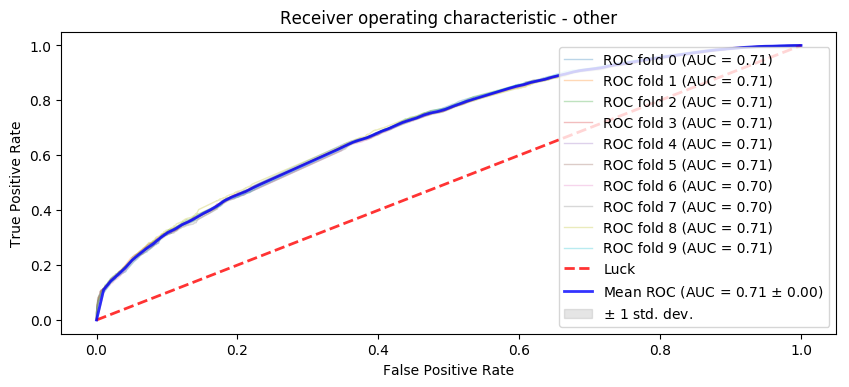

'Testing ransom...'

'ransom: 8939'

'not ransom: 145706'

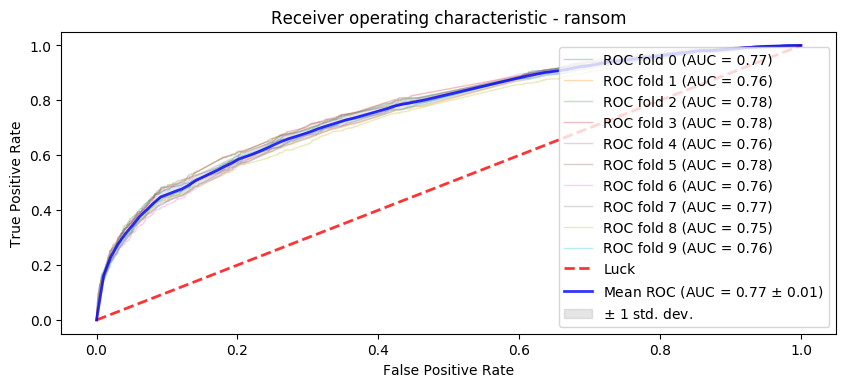

'Testing spyware...'

'spyware: 22994'

'not spyware: 131651'

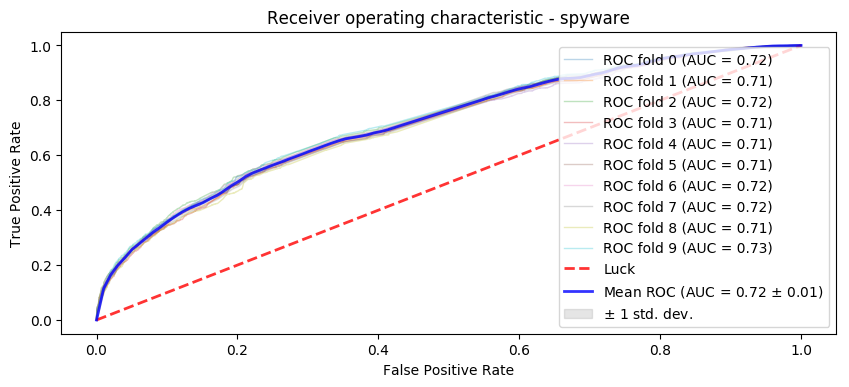

'Testing trojan...'

'trojan: 121394'

'not trojan: 33251'

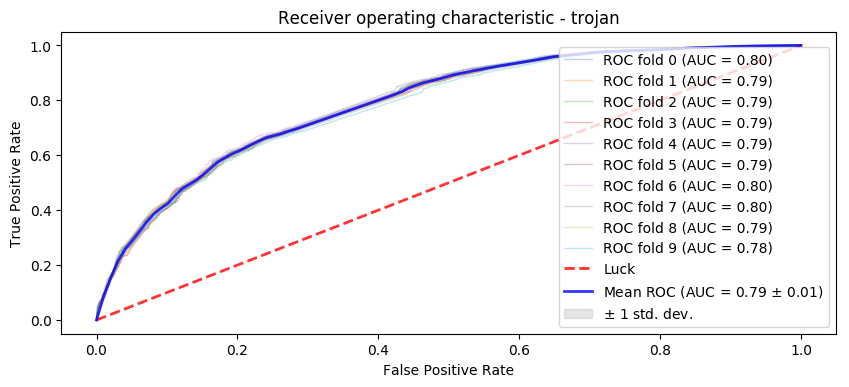

'Testing virus...'

'virus: 23063'

'not virus: 131582'

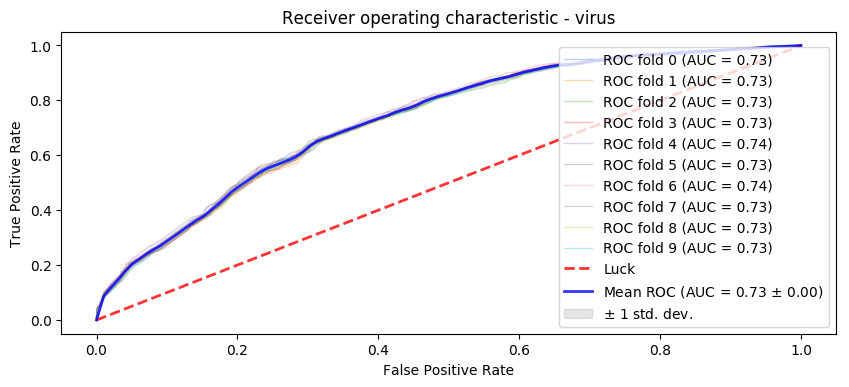

'Testing worm...'

'worm: 25528'

'not worm: 129117'

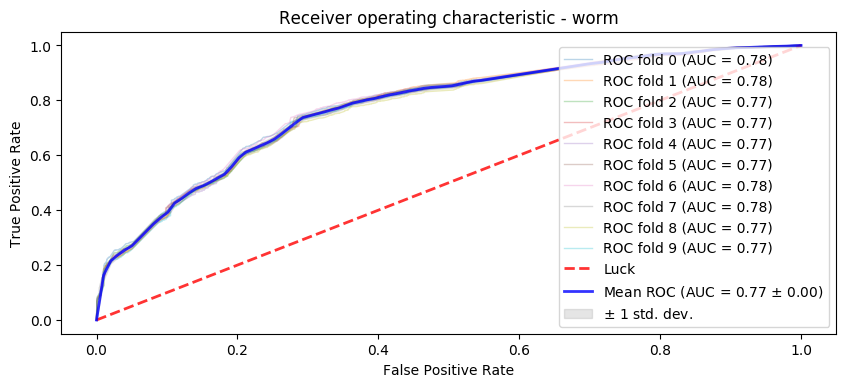

CPU times: user 2min 33s, sys: 1.96 s, total: 2min 35s
Wall time: 2min 33s


In [8]:
%%time
classifiers = dict()
final_rocs = dict()
for mclass in mal_classes:
    display('Testing {}...'.format(mclass))
        
    # Trying ROC
    skf = StratifiedKFold(n_splits=10)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    mal = big_dataset[big_dataset.index.isin(datasets[mclass])]
    not_mal = big_dataset[~big_dataset.index.isin(datasets[mclass])]
    not_mal.loc[:, 'is_malware'] = 0
    display('{}: {}'.format(mclass, len(mal)))
    display('not {}: {}'.format(mclass, len(not_mal)))
    
    assert len(mal) + len(not_mal) == len(big_dataset)
    
    data = shuffle(pd.concat([mal, not_mal]))
    X = cv.transform(data.imports)
    y = data.is_malware
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - {}'.format(mclass))
    plt.legend(loc="lower right")
    plt.show()
    
    final_rocs[mclass] = (mean_fpr, mean_tpr)
    classifiers[mclass] = classifier.fit(X, y)

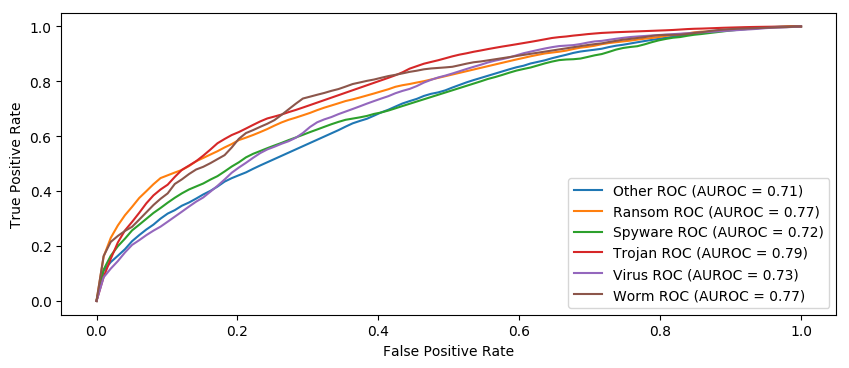

In [9]:
plt.figure(figsize=(10, 4), dpi=100)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
for mclass in mal_classes:
    plt.plot(final_rocs[mclass][0],
             final_rocs[mclass][1],
             label='{} ROC (AUROC = {:.2f})'.format(mclass.capitalize(), auc(final_rocs[mclass][0], final_rocs[mclass][1])))
plt.legend(loc="lower right")
plt.show()

# Malware/Goodware classifier

In [10]:
# Join to big_dataset classification from smaller classifiers
X = cv.transform(big_dataset.imports)
for mclass in mal_classes:
    probs = classifiers[mclass].predict_proba(X)[:,1]
    results = pd.DataFrame(index=big_dataset.index, data=classifiers[mclass].predict_proba(X)[:,1], columns=[mclass])
    big_dataset = big_dataset.join(results)
big_dataset.drop('imports', axis=1, inplace=True)

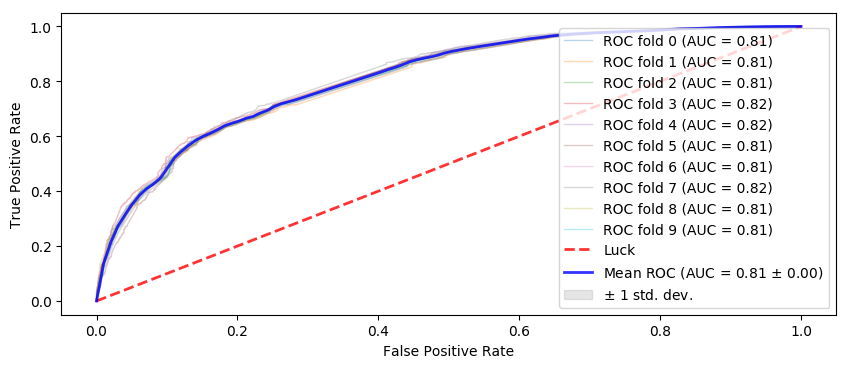

CPU times: user 5.67 s, sys: 5.16 s, total: 10.8 s
Wall time: 3.91 s


In [11]:
%%time
# Trying ROC
skf = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(C=1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X = np.array(big_dataset.iloc[:, 1:])
y = big_dataset.is_malware
plt.figure(figsize=(10, 4), dpi=100)

i = 0
for train, test in skf.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic - TTS')
plt.legend(loc="lower right")
plt.show()